<a href="https://colab.research.google.com/github/MichalSuchocki/T5-text-summarization/blob/main/T5_summarizer_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install sentencepiece
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 31.5 MB/s eta 0:00:00


In [3]:
import seaborn as sns
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import textwrap
from pathlib import Path

import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [6]:
df = pd.read_csv('/content/drive/MyDrive/cnn_dailymail/train.csv', nrows=3000, encoding='latin-1', sep=',', skipinitialspace=True, on_bad_lines='skip')

df.columns
df.head(1)
df = df[['article', 'highlights']]
df.columns=["Text", "Summary"]
df=df.dropna()
df.head(5)

,Text,Summary
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


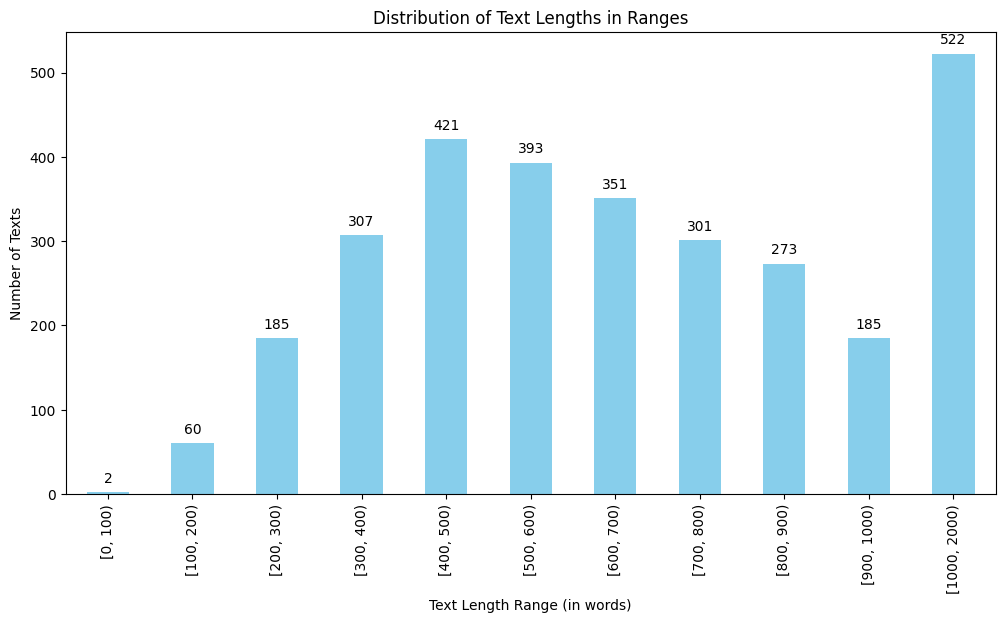

In [8]:
df['Text_Length'] = df['Text'].apply(lambda x: len(str(x).split()))

bins = [i for i in range(0, 1000, 100)] + [i for i in range(1000, max(df['Text_Length']) + 1000, 1000)]
df['Text_Length_Bins'] = pd.cut(df['Text_Length'], bins=bins, right=False)

plt.figure(figsize=(12, 6))
ax = df['Text_Length_Bins'].value_counts().sort_index().plot(kind='bar', color='skyblue')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Text Length Range (in words)')
plt.ylabel('Number of Texts')
plt.title('Distribution of Text Lengths in Ranges')

plt.show()

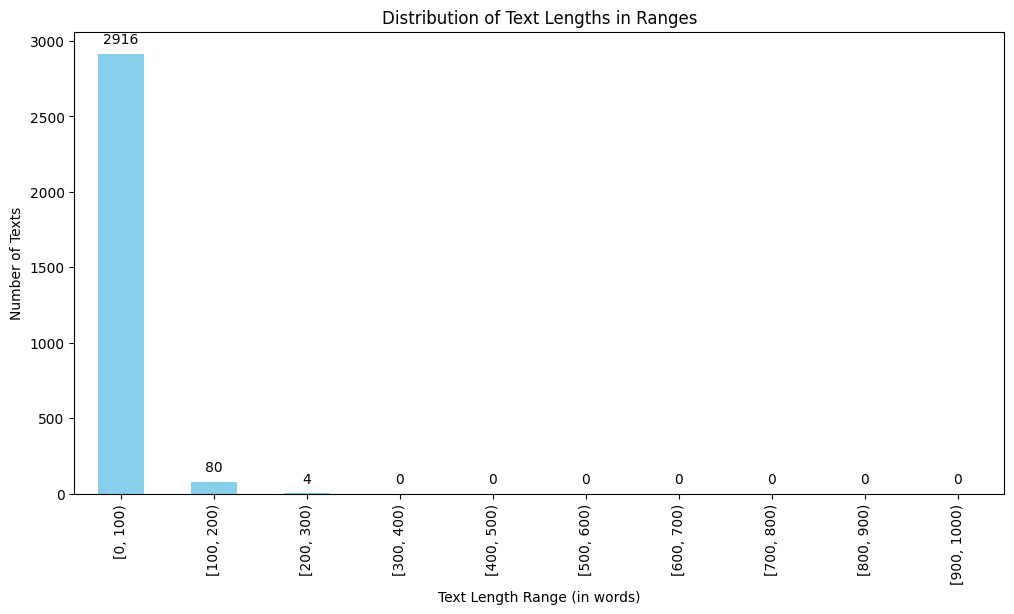

In [10]:
df['Text_Length'] = df['Summary'].apply(lambda x: len(str(x).split()))

bins = [i for i in range(0, 1000, 100)] + [i for i in range(1000, max(df['Text_Length']) + 1000, 1000)]
df['Text_Length_Bins'] = pd.cut(df['Text_Length'], bins=bins, right=False)

plt.figure(figsize=(12, 6))
ax = df['Text_Length_Bins'].value_counts().sort_index().plot(kind='bar', color='skyblue')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Text Length Range (in words)')
plt.ylabel('Number of Texts')
plt.title('Distribution of Text Lengths in Ranges')

plt.show()

In [11]:
train_df, temp_df = train_test_split(df, test_size=0.2)
validation_df, test_df = train_test_split(temp_df, test_size=0.5)
train_df.shape, test_df.shape, validation_df.shape

((2400, 6), (300, 6), (300, 6))

In [12]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128):

        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        text = data_row["Text"]

        text_encoding = tokenizer(data_row["Text"],max_length=self.text_max_token_len,
                                 padding="max_length",
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")

        summary = data_row["Summary"]
        summary_encoding = tokenizer(summary,max_length=self.summary_max_token_len,
                                 padding="max_length",
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")

        labels= summary_encoding["input_ids"]
        labels[labels == 0] = -100

        return dict(
            text=text,
            summary=summary,
            text_input_ids=text_encoding["input_ids"].flatten(),
            text_attention_mask=text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding["attention_mask"].flatten())

In [13]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(self,
                train_df:pd.DataFrame,
                test_df:pd.DataFrame,
                tokenizer:T5Tokenizer,
                batch_size: int = 4,
                text_max_token_len: int = 512,
                summary_max_token_len: int = 128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df

        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len= summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset =  NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset =  NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2)

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)

In [14]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, use_fast = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [15]:
text_token_counts, summary_token_counts = [],[]
for _, row in train_df.iterrows():
    text_token_count=len(tokenizer.encode(row['Text']))
    text_token_counts.append(text_token_count)

    summary_token_count=len(tokenizer.encode(row['Summary']))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (1094 > 512). Running this sequence through the model will result in indexing errors


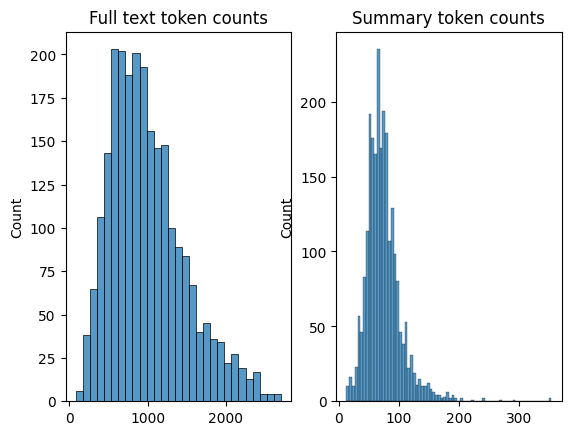

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Full text token counts")

sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary token counts")

fig.show()

In [17]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

In [18]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, inputs_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(inputs_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            decoder_attention_mask=decoder_attention_mask)
        return output.loss, output.logits

    def step(self, batch, batch_idx):
        input_ids=batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self.forward(inputs_ids=input_ids,
                             attention_mask=attention_mask,
                             decoder_attention_mask=labels_attention_mask,
                             labels=labels)
        return loss, outputs

    def training_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)

        self.log("train_loss",loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("val_loss",loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("test_loss",loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [19]:

model = NewsSummaryModel()


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [20]:
from pytorch_lightning.loggers import CSVLogger

In [21]:
checkpoint_callback = ModelCheckpoint(
                        dirpath="checkpoints",
                        filename="best-checkpoint",
                        save_top_k=1,
                        verbose=True,
                        monitor="val_loss",
                        mode="min")

logger = CSVLogger(save_dir="logs/", name="my-model")

from pytorch_lightning.callbacks.progress import ProgressBar
class LitProgressBar(ProgressBar):

    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running validation ...')
        bar.refresh_rate=30
        return bar

bar = LitProgressBar()


trainer = pl.Trainer(enable_checkpointing=checkpoint_callback,
                    max_epochs=N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [22]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [23]:
import time

start_time = time.time()
trainer.fit(model,data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min. in total.")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Training took 20.08 min. in total.


In [26]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
    )

In [27]:
def summarize(text):
    text_encoding = tokenizer(
        text,
        max_length=1024,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
        )
    if torch.cuda.is_available():
        text_encoding = text_encoding.to('cuda:0')
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True)
    if torch.cuda.is_available():
        generated_ids = generated_ids.to('cpu')
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in generated_ids
    ]
    return "".join(preds)

In [28]:
!pip install torchmetrics

In [29]:
from torchmetrics.text.rouge import ROUGEScore
from pprint import pprint

In [32]:
sample_row = test_df.iloc[0]
text = sample_row["Text"]
ref_summary = sample_row["Summary"]

model_summary = summarize(text)

print('Original text :  \n', text)
print('\nPredicted summary :  \n', model_summary)
print('\nOriginal summary :  \n', ref_summary)


Original text :  
 Rugby league has broken new ground by unveiling a major sponsorship deal with a firm of bookmakers. Ladbrokes have been announced by the Rugby Football League as the successors to Tetley's as sponsors of the Challenge Cup. Having weaned itself off a reliance on alcohol and tobacco sponsorship, the RFL took a principled stance three years ago in rejecting an offer from gambling firm Betfair for the naming rights to Super League in favour of a cashless deal with Stobart. Castleford Tigers celebrate at full time after their 2014 Challenge Cup semi-final win over Widnes Vikings . That decision was taken following a personal plea by then RFL executive chairman Richard Lewis but the current regime at Red Hall have adopted a more pragmatic stance since he left to take up the role of chief executive of the All England Club at Wimbledon in April 2012. Stobart were ditched after 12 months following pressure by the top-flight clubs and replaced as Super League sponsors by energ

In [33]:

preds = model_summary
target = ref_summary
rouge = ROUGEScore()
pprint(rouge(preds, target))

{'rouge1_fmeasure': tensor(0.5312),
 'rouge1_precision': tensor(0.4857),
 'rouge1_recall': tensor(0.5862),
 'rouge2_fmeasure': tensor(0.3226),
 'rouge2_precision': tensor(0.2941),
 'rouge2_recall': tensor(0.3571),
 'rougeL_fmeasure': tensor(0.4688),
 'rougeL_precision': tensor(0.4286),
 'rougeL_recall': tensor(0.5172),
 'rougeLsum_fmeasure': tensor(0.5312),
 'rougeLsum_precision': tensor(0.4857),
 'rougeLsum_recall': tensor(0.5862)}
